Challenge

Now take your Keras skills and go build another neural network. Pick your data set, but it should be one of abstract types, possibly even nonnumeric, and use Keras to make five implementations of your network. Compare them both in computational complexity as well as in accuracy and given that tradeoff decide which one you like best.

Your dataset should be sufficiently large for a neural network to perform well (samples should really be in the thousands here) and try to pick something that takes advantage of neural networks’ ability to have both feature extraction and supervised capabilities, so don’t pick something with an easy to consume list of features already generated for you (though neural networks can still be useful in those contexts).

In [235]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [236]:
pwd

'C:\\Users\\18644\\Desktop\\THINKFUL\\Data Science Bootcamp\\UNIT 6'

About the dataset: 
NASA's Magellan (https://www2.jpl.nasa.gov/magellan/) spacecraft was launched on May 4, 1989 and arrived at Venus on August 10, 1990. The primary objectives of the Magellan mission were to map the surface of Venus with a synthetic aperture radar (SAR) and to determine the topographic relief of the planet. At the completion of radar mapping 98% of the surface was imaged at resolutions better than 100 m, and many areas were imaged multiple times. In the analysis of the data captured by the spacecraft they found volcanoes on the surface on Venus, volcanoes that can be used to make a automatic machine that can detect them.
Content We present the data split into train and test. The input data (train_images.csv and test_images.csv) consist on Images of one chanel 110x110, pixels from 0 to 255, where every image is one row of 12100 columns (all the 110 rows of 110 columns), this images can contain more then one volcano or maybe none . Associated to this we present the label data or "ground truth" (train_labels.csv and test_labels.csv), which contains four columns, described here:
Volcano?: if in the image there are volcanoes (Main target), 1 or 0. for Volcano?=0 this three next features are NaN * Type: 1= definitely a volcano,2 =probably, 3= possibly, 4= only a pit is visible * Radius: is the radius of the volcano in the center of the image, in pixels * Number Volcanoes: The number of volcanoes in the image
The images that have volcanoes, have one centered on the image. The authors quote "ground truth" as a reminder that there is no absolute ground truth for this dataset. No one has been to Venus and image quality does not permit 100%, unambiguos identification of the volcanoes, even by human experts.

The dataset has been divided into train and test sets in the source

In [237]:
X_train = pd.read_csv('train_images.csv')
y_train = pd.read_csv('train_labels.csv')

X_test = pd.read_csv('test_images.csv')
y_test = pd.read_csv('test_labels.csv')

In [238]:
X_train.head()

,95,101,99,103,95.1,86,96,89,70,104,...,111.214,107.329,92.354,89.258,103.379,99.414,117.112,116.103,118.82,96.423
0,91,92,91,89,92,93,96,101,107,104,...,103,92,93,95,98,105,104,100,90,81
1,87,70,72,74,84,78,93,104,106,106,...,84,71,95,102,94,80,91,80,84,90
2,0,0,0,0,0,0,0,0,0,0,...,94,81,89,84,80,90,92,80,88,96
3,114,118,124,119,95,118,105,116,123,112,...,116,113,102,93,109,104,106,117,111,115
4,79,95,90,82,73,74,77,75,82,87,...,90,80,79,78,65,71,62,97,89,73


In [239]:
X_train.shape, y_train.shape

((6999, 12100), (7000, 4))

In [240]:
X_test.shape, y_test.shape

((2733, 12100), (2734, 4))

In [241]:
y_train.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


So we have 6999 flatten images that contain 12100 pixels in train set and 2734 in the test set. 
But we have some big problem here. For train data, we have 6999 images but in labels, we have 7000 labels so there must be one missing image.

If we check above the X_train.head part we can see clearly that the column names are our missing image's pixels. The problem is the indexing of the X_train and X_test and we must reindex this

In [242]:
def XFix(X):
    X.loc[-1] = X.columns.values.astype(float).astype(int)  # adding column names as a new row
    X.index = X.index + 1  # shifting index
    X.sort_index(inplace=True)  # sorting the index
    
XFix(X_train)
XFix(X_test)

In [243]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7000, 12100), (7000, 4), (2734, 12100), (2734, 4))

Text(0.5, 1.0, 'volcanoes in testing set')

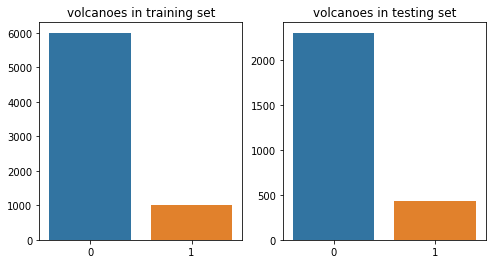

In [244]:
#Let us see how many images on the train and test set have volacanoes
train_counts =y_train['Volcano?'].value_counts()
test_counts = y_test['Volcano?'].value_counts()

plt.figure(figsize = (8,4))
plt.subplot(121)
sns.barplot(train_counts.index, train_counts.values)
plt.title('volcanoes in training set')
plt.subplot(122)
sns.barplot(test_counts.index, test_counts.values)
plt.title('volcanoes in testing set')

Let us visualize some images with and without volcanoes

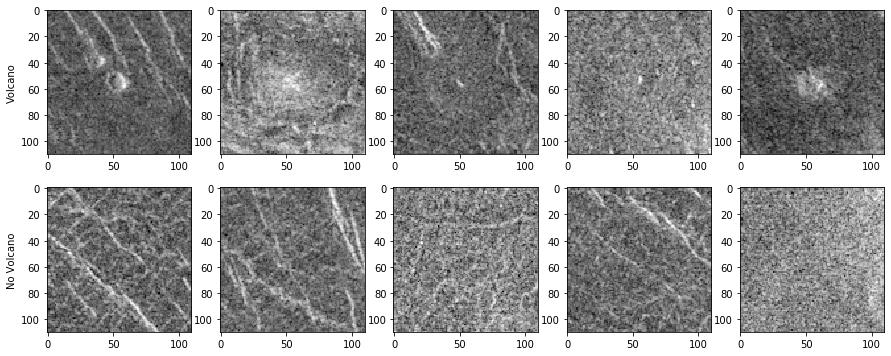

In [245]:
positive_samples = X_train[y_train['Volcano?'] == 1].sample(5)
negative_samples = X_train[y_train['Volcano?'] == 0].sample(5)

plt.subplots(figsize = (15,6))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(positive_samples.iloc[i,:].values.reshape((110, 110)), cmap = 'gray')
    if i == 0: plt.ylabel('Volcano')
for i in range(5):
    plt.subplot(2,5,i+6)
    if i == 0: plt.ylabel('No Volcano')
    plt.imshow(negative_samples.iloc[i,:].values.reshape((110,110)), cmap = 'gray')

Let us normalize the pixel values between 0 and 1

In [246]:
X_train_raw= X_train/256
y_train_raw = y_train['Volcano?']
X_test_raw = X_test/256
y_test_raw = y_test['Volcano?']

Let us split the training set to train and evaluate sets and translate the 7000 images from 1D to 2D

In [247]:
from sklearn.model_selection import train_test_split
img_rows, img_cols = 110, 110

X = X_train_raw.values.reshape((-1, img_rows, img_cols, 1))
y = y_train_raw.values
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size = 0.2, random_state = 3)

X_test = X_test_raw.values.reshape((-1, img_rows, img_cols, 1))
y_test = y_test_raw.values

Building our neural network

In [248]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD

#Import the backend
from keras import backend as K

1. Multi Layer Perceptron

We will start with a simple sequential model using two dense layers of 128 nodes and 64 nodes respectively with a Rectified Linear Unit activation function.

In [16]:
model_dense = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_dense.add(Dense(128, activation='relu', input_shape=(img_rows, img_cols, 1)))
# Dropout layers remove features and fight overfitting
model_dense.add(Dropout(0.1))
model_dense.add(Dense(64, activation='relu'))
model_dense.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model_dense.add(Flatten())
model_dense.add(Dense(1, activation='softmax'))


model_dense.summary()


# Compile the model to put it all together.
model_dense.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_dense = model_dense.fit(X_train, y_train,
                          batch_size=128,
                          epochs=1,
                          verbose=1,
                          validation_data=(X_vali, y_vali))
score = model_dense.evaluate(X_vali, y_vali, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 110, 110, 128)     256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 128)     0         
_________________________________________________________________
dense_2 (Dense)              (None, 110, 110, 64)      8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 774400)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 774401    
T

2. Multilayer perceptron

We will now modify our latter model and add four dense layers, being a total of five, having the following nodes: 256, 128, 128, 128 for each layer respectively, with a Rectified Linear Unit activation funcion.

In [16]:
model_deep = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_deep.add(Dense(256, activation='relu', input_shape=(img_rows, img_cols, 1)))
# Dropout layers remove features and fight overfitting
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
# End with a number of units equal to the number of classes we have for our outcome
model_deep.add(Flatten())
model_deep.add(Dense(1, activation='softmax'))

model_deep.summary()


# Compile the model to put it all together.
model_deep.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_deep = model_deep.fit(X_train, y_train,
                          batch_size=128,
                          epochs=1,
                          verbose=1,
                          validation_data=(X_vali, y_vali))
score = model_deep.evaluate(X_vali, y_vali, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 110, 110, 256)     512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 256)     0         
_________________________________________________________________
dense_2 (Dense)              (None, 110, 110, 128)     32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 110, 110, 128)     0         
_________________________________________________________________
dense_3 (Dense)              (None, 110, 110, 128)     16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 110, 110, 128)     0         
_

3. Convolutional Neural Network

In [249]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, MaxPool2D, Dropout

In [21]:
# kernel_initializer can be tuned for the first conv2D layer
init = keras.initializers.RandomNormal(mean=0, stddev=0.1 )
modelCNN1 = Sequential()
modelCNN1.add(Conv2D(6, kernel_size = (3,3),kernel_initializer=init, activation = 'relu', input_shape = (img_rows, img_cols, 1)))
modelCNN1.add(MaxPool2D(pool_size=(2,2), strides=2))
modelCNN1.add(Dropout(0.5))
modelCNN1.add(Conv2D(12, kernel_size = (3,3), activation = 'relu'))
modelCNN1.add(MaxPool2D(pool_size=(2,2), strides=2))
modelCNN1.add(Dropout(0.5))
modelCNN1.add(Conv2D(24, kernel_size = (3,3), activation = 'relu'))
modelCNN1.add(MaxPool2D(pool_size=(2,2), strides=2))
modelCNN1.add(Dropout(0.5))
modelCNN1.add(Flatten())
modelCNN1.add(Dense(1, activation = 'sigmoid'))

modelCNN1.summary()

# the line bolow can be used for tuning the adam optimizer, e.g. different initial learning rate
# adam = keras.optimizers.Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
modelCNN1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# the callBack parameter can be added to model.fit as 'callbacks = [callBack]' for early termination
from keras.callbacks import EarlyStopping
callBack = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto')


def reset_weights(model):
    session = keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

epochs = 1
batch_size = 64
reset_weights(modelCNN1)            
history = modelCNN1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_vali, y_vali),
                        callbacks=[callBack]
                       )

score = modelCNN1.evaluate(X_vali, y_vali, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 108, 108, 6)       60        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 54, 54, 6)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 54, 54, 6)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 52, 52, 12)        660       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 26, 26, 12)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 26, 26, 12)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 24)       

In [ ]:
4. Convolutional Neural Network with increased(10) epochs

In [20]:
# kernel_initializer can be tuned for the first conv2D layer
init = keras.initializers.RandomNormal(mean=0, stddev=0.1 )
modelCNN1 = Sequential()
modelCNN1.add(Conv2D(6, kernel_size = (3,3),kernel_initializer=init, activation = 'relu', input_shape = (img_rows, img_cols, 1)))
modelCNN1.add(MaxPool2D(pool_size=(2,2), strides=2))
modelCNN1.add(Dropout(0.5))
modelCNN1.add(Conv2D(12, kernel_size = (3,3), activation = 'relu'))
modelCNN1.add(MaxPool2D(pool_size=(2,2), strides=2))
modelCNN1.add(Dropout(0.5))
modelCNN1.add(Conv2D(24, kernel_size = (3,3), activation = 'relu'))
modelCNN1.add(MaxPool2D(pool_size=(2,2), strides=2))
modelCNN1.add(Dropout(0.5))
modelCNN1.add(Flatten())
modelCNN1.add(Dense(1, activation = 'sigmoid'))

modelCNN1.summary()

# the line bolow can be used for tuning the adam optimizer, e.g. different initial learning rate
# adam = keras.optimizers.Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
modelCNN1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# the callBack parameter can be added to model.fit as 'callbacks = [callBack]' for early termination
from keras.callbacks import EarlyStopping
callBack = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto')


def reset_weights(model):
    session = keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

epochs = 10
batch_size = 64
reset_weights(modelCNN1)            
history = modelCNN1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_vali, y_vali),
                        callbacks=[callBack]
                       )
score = modelCNN1.evaluate(X_vali, y_vali, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 108, 108, 6)       60        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 6)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 54, 54, 6)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 12)        660       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 26, 12)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 26, 26, 12)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 24)       

In [ ]:
5. Convolutional Neural Network with increased (10) epochs 

In [254]:
# kernel_initializer can be tuned for the first conv2D layer
init = keras.initializers.RandomNormal(mean=0, stddev=0.1 )
modelCNN3 = Sequential()
modelCNN3.add(Conv2D(6, kernel_size = (3,3),kernel_initializer=init, activation = 'relu', input_shape = (img_rows, img_cols, 1)))
modelCNN3.add(MaxPool2D(pool_size=(2,2), strides=2))
modelCNN3.add(Dropout(0.5))
modelCNN3.add(Conv2D(12, kernel_size = (3,3), activation = 'relu'))
modelCNN3.add(MaxPool2D(pool_size=(2,2), strides=2))
modelCNN3.add(Dropout(0.5))
modelCNN3.add(Conv2D(24, kernel_size = (3,3), activation = 'relu'))
modelCNN3.add(MaxPool2D(pool_size=(2,2), strides=2))
modelCNN3.add(Dropout(0.5))
modelCNN3.add(Flatten())
modelCNN3.add(Dense(1, activation = 'sigmoid'))

modelCNN3.summary()


# the line bolow can be used for tuning the adam optimizer, e.g. different initial learning rate
# adam = keras.optimizers.Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
modelCNN3.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# the callBack parameter can be added to model.fit as 'callbacks = [callBack]' for early termination
from keras.callbacks import EarlyStopping
callBack = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto')


def reset_weights(model):
    session = keras.backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


epochs = 15
batch_size = 64
reset_weights(modelCNN1)            
history = modelCNN3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_vali, y_vali),
                        callbacks=[callBack]
                       )
score = modelCNN3.evaluate(X_vali, y_vali, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 108, 108, 6)       60        
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 54, 54, 6)         0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 54, 54, 6)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 52, 52, 12)        660       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 26, 26, 12)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 26, 26, 12)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 24)       

Let us try  fitting the model using traditional supervised learning algorithms 

Logitic Regression reducing 2D image to 1D

In [209]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [210]:
Xtrain, Xvali, ytrain, yvali = train_test_split(X_train_raw, y_train_raw, test_size = 0.3, random_state = 3)
Xtest, ytest = X_test_raw, y_test_raw

lrm = LogisticRegression()

from time import time
start = time()

lrm.fit(Xtrain, ytrain)
end = time()
print('Accuracy score:', lrm.score(Xtrain, ytrain))
print('training time: {} mins.'.format((end-start)/60))

C:\Users\18644\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score: 0.9993877551020408
training time: 0.5476592699686686 mins.


In [116]:
from sklearn.metrics import classification_report
predVali = lrm.predict(Xvali)
predTest = lrm.predict(Xtest)
print('validation report:','\n',classification_report(yvali, predVali))
print('testing report:', '\n', classification_report(ytest, predTest))

validation report: 
               precision    recall  f1-score   support

           0       0.94      0.98      0.96      1798
           1       0.85      0.60      0.70       302

    accuracy                           0.93      2100
   macro avg       0.89      0.79      0.83      2100
weighted avg       0.92      0.93      0.92      2100

testing report: 
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      2300
           1       0.86      0.59      0.70       434

    accuracy                           0.92      2734
   macro avg       0.90      0.78      0.83      2734
weighted avg       0.92      0.92      0.91      2734



Logistic regression gives the accuracy of 99% however, it is because of the data imbalance as we can see recall score of 59% on the test data.

Conlcusion
After running different models with different hyperparatmeters, I can say that the final model: Convolutional neural network was the most efficient given it's low running time and high accuracy(89%) in test set. We can of course tune even more the different parameters, and try to optimize our model yielding a higher result. 